# Notebook to convert the Audio data into spectrograms and folder splits
## To be used for artificially expanding the dataset

- Converting the the audio files to square Mel-spectrograms, and saving in spectrograms/(BigRoom, DrumAndBass, Techno)
- Splitting into train, validate, test folders

In [1]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("Blues", as_cmap=True)

# Standard Packages
import numpy as np
import warnings
import pandas as pd
import os
import shutil
import random
import time
import PIL
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#for loading and visualizing audio files
import librosa
import librosa.display
from scipy import signal
from scipy.io import wavfile
import wave
from pydub import AudioSegment

#to play audio
import IPython.display as ipd

random.seed(123)

### Getting list of genre_names and setting the audio_fpath variable

In [2]:
audio_fpath = "../data/subgenre_dataset/"
genre_names = os.listdir(audio_fpath)
print(genre_names)

['Breaks', 'BigRoom', 'PsyTrance', 'TechHouse', 'ReggaeDub', 'ElectronicaDowntempo', '.DS_Store', 'IndieDanceNuDisco', 'HardcoreHardTechno', 'Trance', 'Minimal', 'ElectroHouse', 'Dance', 'DrumAndBass', 'HipHop', 'GlitchHop', 'House', 'HardDance', 'ProgressiveHouse', 'FutureHouse', 'FunkRAndB', 'Dubstep', 'DeepHouse', 'Techno']


### Getting list of file paths for the 3 selected genres

In [3]:
big_room_file_paths = sorted([audio_fpath + 'BigRoom/' + f for f in os.listdir(audio_fpath + 'BigRoom/') if '.wav' in f])
# big_room_file_paths

In [4]:
dnb_file_paths = sorted([audio_fpath + 'DrumAndBass/' + f for f in os.listdir(audio_fpath + 'DrumAndBass/') if '.wav' in f])
# dnb_file_paths

In [5]:
techno_file_paths = sorted([audio_fpath + 'Techno/' + f for f in os.listdir(audio_fpath + 'Techno/') if '.wav' in f])
# techno_file_paths

### Previewing one song from each genre with ipd

In [6]:
# ipd.Audio(big_room_file_paths[0], autoplay=True)

In [7]:
# ipd.Audio(dnb_file_paths[0], autoplay=True)

In [8]:
# ipd.Audio(techno_file_paths[0], autoplay=True)

## Create spectrogram dataset from the audio files

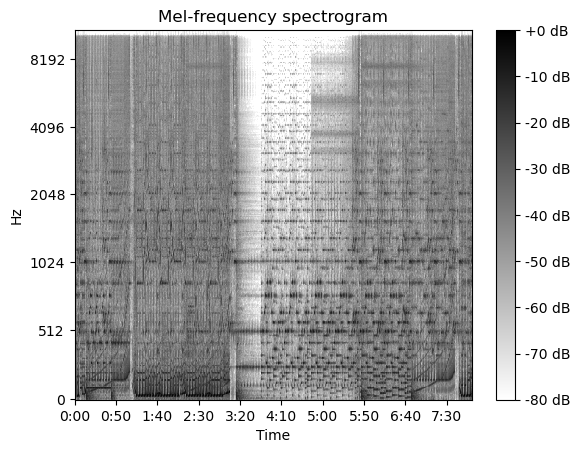

In [9]:
def view_mel_spectrogram(audio_path):
    
    # In very high quality
    
    # Load audio file
    y, sr = librosa.load(audio_path)          # sr = 22050, mono=True by default

    # Compute Mel spectrogram
    n_fft = 8192              # Should be smaller than half the sample rate sr (max being 11025)
    hop_length = 128          # Smaller value => better time resolution. <= n_fft/2. Center of window 1 at y[t * hop_length]
    n_mels = 512              # Larger value increases frequency resolution. Way more time to run
    
    # Frequency range to approximately match human hearing
    fmin = 20
    fmax = 11025
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, 
                                       n_mels=n_mels, fmax=fmax, fmin=fmin)

    # Convert to decibels
    S_dB = librosa.power_to_db(S, ref=np.max)

    
    # To view colorbar and axes
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', cmap='gray_r')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.show()

view_mel_spectrogram(big_room_file_paths[0])

#### Function that converts to spectrogram, saves it to a file with path: ../spectrograms/halves/'genre_name' and plots it in the notebook

In [10]:
def save_mel_spectrograms(audio_path):

    # Load audio file
    y, sr = librosa.load(audio_path)          # sr = 22050, mono=True by default

    
    ### Set Mel Spectrogram Hyperparameters ###
    # Use powers of 2 because it helps with algorithm efficiency
    
    # Increase n_fft (default 4096) to increase fft window size --> Increase frequency resolution. more time
    # Should be smaller than half the sample rate sr (max being 11025 here)
    n_fft = 8192
    
    # Decrease hop_length (default 512) for better time resolution. <= n_fft/2. Center of window 1 at y[t * hop_length]
    hop_length = 128          # Smaller value => better time resolution. <= n_fft/2. 
    
    # Increase n_mels (default 128) to increase frequency resolution
    n_mels = 512              
    
    # Frequency range to approximately match human hearing
    fmin = 20
    fmax = 11025
    
    # Compute Mel spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, 
                                       n_mels=n_mels, fmax=fmax, fmin=fmin)
    
    # Convert to decibels
    S_dB = librosa.power_to_db(S, ref=np.max)

    
    ######Display & Save Mel Spectrograms######
    
    ###Full 2 minutes###
    plt.figure(figsize=(6, 6))
    librosa.display.specshow(S_dB, sr=sr, n_fft=n_fft, hop_length=hop_length, fmax=fmax, fmin=fmin, cmap='gray_r')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../spectrograms/high_res/full/' + audio_path.split('/')[-2] + '/' 
                + audio_path.split('/')[-1].split('.')[0],  
                bbox_inches='tight', pad_inches=0, dpi=1200)
        
    
    ###Cut in half - Two 1 minute images###
    window_length_half = S_dB.shape[1]//2             # Width of image to chop up 5169//2 = 2584
    prev_half = 0                                     # Beginning of range for each chunk of image
    
    for x in range(2):    
        plt.figure(figsize=(6, 6))
        librosa.display.specshow(S_dB[:, prev_half:prev_half + window_length_half], sr=sr, n_fft=n_fft, 
                                 hop_length=hop_length, fmax=fmax, fmin=fmin, cmap='gray_r')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('../spectrograms/high_res/halves/' + audio_path.split('/')[-2] + '/' 
                    + audio_path.split('/')[-1].split('.')[0] + '_half' + str(x+1),  
                    bbox_inches='tight', pad_inches=0, dpi=1200)
        prev_half += window_length_half
    
    
    ###Cut into quarters - Four 30 second images###
    window_length_quarter = S_dB.shape[1]//4             # Width of image to chop up 5169//4 = 1292
    prev_quarter = 0                                     # Beginning of range for each chunk of image
    
    for x in range(4):
        plt.figure(figsize=(6, 6))
        librosa.display.specshow(S_dB[:, prev_quarter:prev_quarter + window_length_quarter], sr=sr, n_fft=n_fft, 
                                 hop_length=hop_length, fmax=fmax, fmin=fmin, cmap='gray_r')

        plt.axis('off')
        plt.tight_layout()
        plt.savefig('../spectrograms/high_res/quarters/' + audio_path.split('/')[-2] + '/' 
                    + audio_path.split('/')[-1].split('.')[0] + '_quarter' + str(x+1),  
                    bbox_inches='tight', pad_inches=0, dpi=1200)
        prev_quarter += window_length_quarter
        
    return S_dB


# test = save_mel_spectrograms(dnb_file_paths[0])

#### Loop that creates the image datasets for BigRoom, DrumAndBass, and Techno

This will crash the kernel if it loops for 24+ iterations because it is saving too much image data to memory. Need to fix later

In [12]:
# start_time = time.time()
# for i, (b, d, t) in enumerate(zip(big_room_file_paths, dnb_file_paths, techno_file_paths)):
#     iter_start_time = time.time()
#     save_mel_spectrograms(b)
#     save_mel_spectrograms(d)
#     save_mel_spectrograms(t)
#     print('Iteration ' + str(i) + ': ' + str(time.time() - iter_start_time))
# print(time.time() - start_time)

## Train, Validate, Test Split - Full

In [29]:
# Set the root directory containing the subdirectories for each class
root_dir = '../spectrograms/high_res/full/'

# Create the train, validation, and test directories
train_dir = root_dir + 'train/'
val_dir = root_dir + 'validate/'
test_dir = root_dir + 'test/'

In [30]:
###### DO NOT RE-RUN WITHOUT DELETING PREVIOUS DIRECTORIES ######


# Set the names of the subdirectories for each class
class_names = ['BigRoom', 'DrumAndBass', 'Techno']

# Set the proportion of images to use for train, validation, and test
train_prop = 0.7
val_prop = 0.15
test_prop = 0.15

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop over each class
for class_name in class_names:
    # Create subdirectories for each class in the train, validation, and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get the list of image filenames for the current class
    image_filenames = [x for x in os.listdir(os.path.join(root_dir, class_name)) if '.png' in x]

#     # Shuffle the list of image filenames - NOT SHUFFLING FOR NOW - USE SEED IF SO 
    
    random.shuffle(image_filenames)

    # Split the image filenames into train, validation, and test sets
    num_images = len(image_filenames)
    num_train = int(num_images * train_prop)
    num_val = int(num_images * val_prop)
    num_test = int(num_images * test_prop)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train+num_val]
    test_filenames = image_filenames[num_train+num_val:]

    # Copy the images to the appropriate train, validation, or test directory
    for filename in train_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(train_dir, class_name, filename)
        shutil.copy(src_path, dest_path)

    for filename in val_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(val_dir, class_name, filename)
        shutil.copy(src_path, dest_path)

    for filename in test_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(test_dir, class_name, filename)
        shutil.copy(src_path, dest_path)


## Train, Validate, Test Split - Halves

In [31]:
# Set the root directory containing the subdirectories for each class
root_dir = '../spectrograms/high_res/halves/'

# Create the train, validation, and test directories
train_dir = root_dir + 'train/'
val_dir = root_dir + 'validate/'
test_dir = root_dir + 'test/'

In [32]:
###### DO NOT RE-RUN WITHOUT DELETING PREVIOUS DIRECTORIES ######


# Set the names of the subdirectories for each class
class_names = ['BigRoom', 'DrumAndBass', 'Techno']

# Set the proportion of images to use for train, validation, and test
train_prop = 0.7
val_prop = 0.15
test_prop = 0.15
## Train, Validate, Test Split - Halves
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop over each class
for class_name in class_names:
    # Create subdirectories for each class in the train, validation, and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get the list of image filenames for the current class
    image_filenames = [x for x in os.listdir(os.path.join(root_dir, class_name)) if '.png' in x]

#     # Shuffle the list of image filenames - NOT SHUFFLING FOR NOW - USE SEED IF SO 
    
    random.shuffle(image_filenames)

    # Split the image filenames into train, validation, and test sets
    num_images = len(image_filenames)
    num_train = int(num_images * train_prop)
    num_val = int(num_images * val_prop)
    num_test = int(num_images * test_prop)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train+num_val]
    test_filenames = image_filenames[num_train+num_val:]

    # Copy the images to the appropriate train, validation, or test directory
    for filename in train_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(train_dir, class_name, filename)
        shutil.copy(src_path, dest_path)

    for filename in val_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(val_dir, class_name, filename)
        shutil.copy(src_path, dest_path)

    for filename in test_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(test_dir, class_name, filename)
        shutil.copy(src_path, dest_path)


## Train, Validate, Test Split - Quarters

In [33]:
# Set the root directory containing the subdirectories for each class
root_dir = '../spectrograms/high_res/quarters/'

# Create the train, validation, and test directories
train_dir = root_dir + 'train/'
val_dir = root_dir + 'validate/'
test_dir = root_dir + 'test/'

In [34]:
###### DO NOT RE-RUN WITHOUT DELETING PREVIOUS DIRECTORIES ######


# Set the names of the subdirectories for each class
class_names = ['BigRoom', 'DrumAndBass', 'Techno']

# Set the proportion of images to use for train, validation, and test
train_prop = 0.7
val_prop = 0.15
test_prop = 0.15
## Train, Validate, Test Split - Halves
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop over each class
for class_name in class_names:
    # Create subdirectories for each class in the train, validation, and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get the list of image filenames for the current class
    image_filenames = [x for x in os.listdir(os.path.join(root_dir, class_name)) if '.png' in x]

#     # Shuffle the list of image filenames - NOT SHUFFLING FOR NOW - USE SEED IF SO 
    
    random.shuffle(image_filenames)

    # Split the image filenames into train, validation, and test sets
    num_images = len(image_filenames)
    num_train = int(num_images * train_prop)
    num_val = int(num_images * val_prop)
    num_test = int(num_images * test_prop)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train+num_val]
    test_filenames = image_filenames[num_train+num_val:]

    # Copy the images to the appropriate train, validation, or test directory
    for filename in train_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(train_dir, class_name, filename)
        shutil.copy(src_path, dest_path)

    for filename in val_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(val_dir, class_name, filename)
        shutil.copy(src_path, dest_path)

    for filename in test_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(test_dir, class_name, filename)
        shutil.copy(src_path, dest_path)
